<a href="https://colab.research.google.com/github/why-arong/fake-voice-detection/blob/mel-resnet/mel_resnet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget 'https://drive.usercontent.google.com/download?id=1HLBDBTnrLvVdqXxMQTDJyTUf5ryBqcxD&export=download&authuser=1&confirm=t' -O open.zip

--2024-07-01 12:39:06--  https://drive.usercontent.google.com/download?id=1HLBDBTnrLvVdqXxMQTDJyTUf5ryBqcxD&export=download&authuser=1&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.117.132, 2607:f8b0:400e:c0a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.117.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313752771 (3.1G) [application/octet-stream]
Saving to: ‘open.zip’

open.zip            100%[===================>]   3.09G   149MB/s    in 35s     

2024-07-01 12:39:42 (89.8 MB/s) - ‘open.zip’ saved [3313752771/3313752771]



In [ ]:
!unzip -q open.zip

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import librosa

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SR = 32000
SEED = 1
BATCH = 32
EPOCH = 10
LR = 1e-4

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, shape=(128, 64), fixed_len=32000):
        self.file_paths = file_paths
        self.labels = labels
        self.shape = shape
        self.fixed_len = fixed_len

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        raw, sr = librosa.load(file_path, sr=SR)

        # padding or clip to convert to fixed length
        length = len(raw)
        if length < self.fixed_len:
            to_pad = self.fixed_len - length
            left_pad = np.random.randint(0, to_pad + 1)
            right_pad = to_pad - left_pad
            raw = np.pad(raw, (left_pad, right_pad), mode='constant')
        else:
            start = np.random.randint(0, length - self.fixed_len + 1)
            raw = raw[start:start + self.fixed_len]

        # extract feature
        n_mels = self.shape[0]
        hop_length = self.fixed_len // self.shape[1] + 1
        data = librosa.feature.melspectrogram(y=raw, n_mels=n_mels, hop_length=hop_length)
        data = librosa.power_to_db(data, ref=np.max)

        # normalize
        data = (data - np.mean(data)) / np.std(data)

        data = torch.tensor(data).unsqueeze(0)
        label = torch.tensor(label)

        return data, label

In [ ]:
train = pd.read_csv("train.csv")
train["label"] = train["label"].apply(lambda x: 1 if x == "real" else 0)

train.head()

,id,path,label
0,RUNQPNJF,./train/RUNQPNJF.ogg,1
1,JFAWUOGJ,./train/JFAWUOGJ.ogg,0
2,RDKEKEVX,./train/RDKEKEVX.ogg,1
3,QYHJDOFK,./train/QYHJDOFK.ogg,1
4,RSPQNHAO,./train/RSPQNHAO.ogg,1


In [ ]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train["path"].values, train["label"].values, test_size=0.2, stratify=train["label"]
)

train_dataset = AudioDataset(train_paths, train_labels)
valid_dataset = AudioDataset(valid_paths, valid_labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, stride=stride)
        self.conv2 = ConvBlock(out_channels, out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + shortcut
        x = self.relu(x)
        return x

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = ConvBlock(1, 16)
        self.res1 = ResBlock(16, 16)
        self.res2 = ResBlock(16, 32, stride=2)
        self.res3 = ResBlock(32, 32)
        self.res4 = ResBlock(32, 64, stride=2)
        self.res5 = ResBlock(64, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
model = AudioClassifier(1).to(device)

summary(model, input_size=(1, 128, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 128, 64]             160
       BatchNorm2d-2          [-1, 16, 128, 64]              32
              ReLU-3          [-1, 16, 128, 64]               0
         ConvBlock-4          [-1, 16, 128, 64]               0
          Identity-5          [-1, 16, 128, 64]               0
            Conv2d-6          [-1, 16, 128, 64]           2,320
       BatchNorm2d-7          [-1, 16, 128, 64]              32
              ReLU-8          [-1, 16, 128, 64]               0
         ConvBlock-9          [-1, 16, 128, 64]               0
           Conv2d-10          [-1, 16, 128, 64]           2,320
      BatchNorm2d-11          [-1, 16, 128, 64]              32
             ReLU-12          [-1, 16, 128, 64]               0
        ConvBlock-13          [-1, 16, 128, 64]               0
             ReLU-14          [-1, 16, 

In [ ]:
def run_epoch(model, dataloader, optimizer, criterion, train=True):
    total_loss = 0
    count = 0
    correct = 0

    if train:
        model.train()
    else:
        model.eval()

    for data, labels in tqdm(dataloader, desc="Training" if train else "Evaluating"):
        data = data.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(data).squeeze()
        loss = criterion(outputs, labels)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        count += len(labels)
        correct += ((outputs > 0.5).float() == labels).sum().item()

    return total_loss / count, correct / count

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

best_accuracy = 0
best_model = None

for epoch in range(EPOCH):
    print(f"Epoch {epoch}")

    train_loss, train_accuracy = run_epoch(model, train_dataloader, optimizer, criterion, train=True)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")

    valid_loss, valid_accuracy = run_epoch(model, valid_dataloader, optimizer, criterion, train=False)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f"Test Loss: {valid_loss:.4f}")
    print(f"Test Accuracy: {valid_accuracy:.4f}")

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_model = model

Epoch 0


Training: 100%|██████████| 1386/1386 [13:30<00:00,  1.71it/s]


Train Loss: 0.0052
Train Accuracy: 0.9469


Evaluating: 100%|██████████| 347/347 [03:09<00:00,  1.83it/s]


Test Loss: 0.0014
Test Accuracy: 0.9943
Epoch 1


Training: 100%|██████████| 1386/1386 [13:34<00:00,  1.70it/s]


Train Loss: 0.0013
Train Accuracy: 0.9901


Evaluating: 100%|██████████| 347/347 [03:14<00:00,  1.78it/s]


Test Loss: 0.0013
Test Accuracy: 0.9948
Epoch 2


Training: 100%|██████████| 1386/1386 [13:19<00:00,  1.73it/s]


Train Loss: 0.0008
Train Accuracy: 0.9934


Evaluating: 100%|██████████| 347/347 [03:08<00:00,  1.85it/s]


Test Loss: 0.0012
Test Accuracy: 0.9920
Epoch 3


Training: 100%|██████████| 1386/1386 [13:21<00:00,  1.73it/s]


Train Loss: 0.0006
Train Accuracy: 0.9949


Evaluating: 100%|██████████| 347/347 [03:09<00:00,  1.83it/s]


Test Loss: 0.0004
Test Accuracy: 0.9966
Epoch 4


Training: 100%|██████████| 1386/1386 [13:21<00:00,  1.73it/s]


Train Loss: 0.0005
Train Accuracy: 0.9950


Evaluating: 100%|██████████| 347/347 [03:06<00:00,  1.86it/s]


Test Loss: 0.0007
Test Accuracy: 0.9906
Epoch 5


Training: 100%|██████████| 1386/1386 [13:01<00:00,  1.77it/s]


Train Loss: 0.0004
Train Accuracy: 0.9962


Evaluating: 100%|██████████| 347/347 [03:00<00:00,  1.92it/s]


Test Loss: 0.0003
Test Accuracy: 0.9964
Epoch 6


Training: 100%|██████████| 1386/1386 [12:58<00:00,  1.78it/s]


Train Loss: 0.0003
Train Accuracy: 0.9967


Evaluating: 100%|██████████| 347/347 [03:01<00:00,  1.91it/s]


Test Loss: 0.0009
Test Accuracy: 0.9867
Epoch 7


Training: 100%|██████████| 1386/1386 [12:53<00:00,  1.79it/s]


Train Loss: 0.0003
Train Accuracy: 0.9968


Evaluating: 100%|██████████| 347/347 [03:00<00:00,  1.92it/s]


Test Loss: 0.0002
Test Accuracy: 0.9977
Epoch 8


Training: 100%|██████████| 1386/1386 [13:10<00:00,  1.75it/s]


Train Loss: 0.0003
Train Accuracy: 0.9969


Evaluating: 100%|██████████| 347/347 [03:03<00:00,  1.89it/s]


Test Loss: 0.0001
Test Accuracy: 0.9989
Epoch 9


Training: 100%|██████████| 1386/1386 [13:11<00:00,  1.75it/s]


Train Loss: 0.0003
Train Accuracy: 0.9972


Evaluating: 100%|██████████| 347/347 [03:03<00:00,  1.89it/s]

Test Loss: 0.0002
Test Accuracy: 0.9975


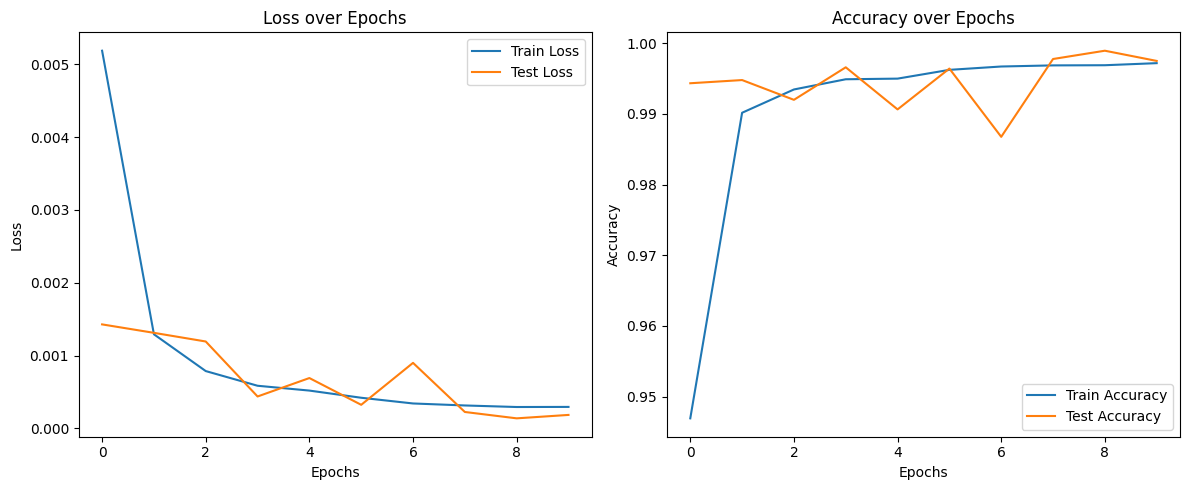

In [ ]:
epochs_range = range(EPOCH)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, valid_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(best_model.state_dict(), "mel_resnet_v1.pth")